# Tutorial 2: Adding a Forgetting Mechanism

In this tutorial, you will learn how to use SPICE for learning forgetting mechanisms for the not chosen actions.

This module incorporates an additional RNN module which dynamically handles the reward-based values for the not-chosen action.

## 1. Data generation
First, we simulate a synthetic dataset from a Q-learning agent performing the two-armed bandit task, as in the previous tutorial. This time we specify a forgetting rate.

In [1]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

In [2]:
from spice.resources.bandits import BanditsDrift, AgentQ, create_dataset

# Set up the environment
n_actions = 2
sigma = 0.2

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

# Set up the agent
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.3,
    forget_rate=0.2,
)

# Create the dataset
n_trials = 200
n_sessions = 256

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating dataset...


100%|██████████| 256/256 [00:01<00:00, 171.85it/s]


## 2. Using the precoded Rescorla-Wagner RNN with Forgetting Mechanism

First we will use the precoded RNN with the forgetting mechanism. This is basically the Rescorla-Wagner RNN with an additional mechanism for the not chosen action. Later, you will see how to implement it yourself.

In [8]:
from spice.estimator import SpiceEstimator
from spice.precoded import ForgettingRNN, FORGETTING_RNN_CONFIG

spice_estimator = SpiceEstimator(
    rnn_class=ForgettingRNN,
    spice_config=FORGETTING_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_optim_threshold=0.05,
    spice_optim_regularization=0.1,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 0.9014803; Time: 0.09s; Convergence: 5.49e-01
Epoch 2/1024 --- L(Train): 0.8211533; Time: 0.07s; Convergence: 3.15e-01
Epoch 3/1024 --- L(Train): 0.7698964; Time: 0.08s; Convergence: 1.83e-01
Epoch 4/1024 --- L(Train): 0.7358894; Time: 0.07s; Convergence: 1.09e-01
Epoch 5/1024 --- L(Train): 0.7123762; Time: 0.08s; Convergence: 6.60e-02
Epoch 6/1024 --- L(Train): 0.6961121; Time: 0.07s; Convergence: 4.11e-02
Epoch 7/1024 --- L(Train): 0.6853630; Time: 0.08s; Convergence: 2.59e-02
Epoch 8/1024 --- L(Train): 0.6787186; Time: 0.07s; Convergence: 1.63e-02
Epoch 9/1024 --- L(Train): 0.6747891; Time: 0.07s; Convergence: 1.01e-02
Epoch 10/1024 --- L(Train): 0.6723477; Time: 0.07s; Convergence: 6.28e-03
Epoch 11/1024 --- L(Train): 0.6705397; Time: 0.08s; Convergence: 4.04e-03
Epoch 12/1024 --- L(Train): 0.6689053; Time: 0.07s; Convergence: 2.84e-03
Epoch 13/1024 --- L(Train): 0.6672286; Time: 0.08s; Convergence: 2.26e-03
Epoch 14/1024 --- L(Train)

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.6040e-02 ... 7.5000e-02 ... 4.8558e-02 ... 1.0210e-01
(x_value_reward_chosen)[k+1] = -0.329 1 + 0.706 x_value_reward_chosen[k] + 0.908 c_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 7.2411e-02 ... 5.0000e-02 ... 2.2289e-02 ... 9.9701e-02
(x_value_reward_not_chosen)[k+1] = 0.107 1 + 0.784 x_value_reward_not_chosen[k]


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

SPICE training finished.
Training took 25.84 seconds.


Let's see how our model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

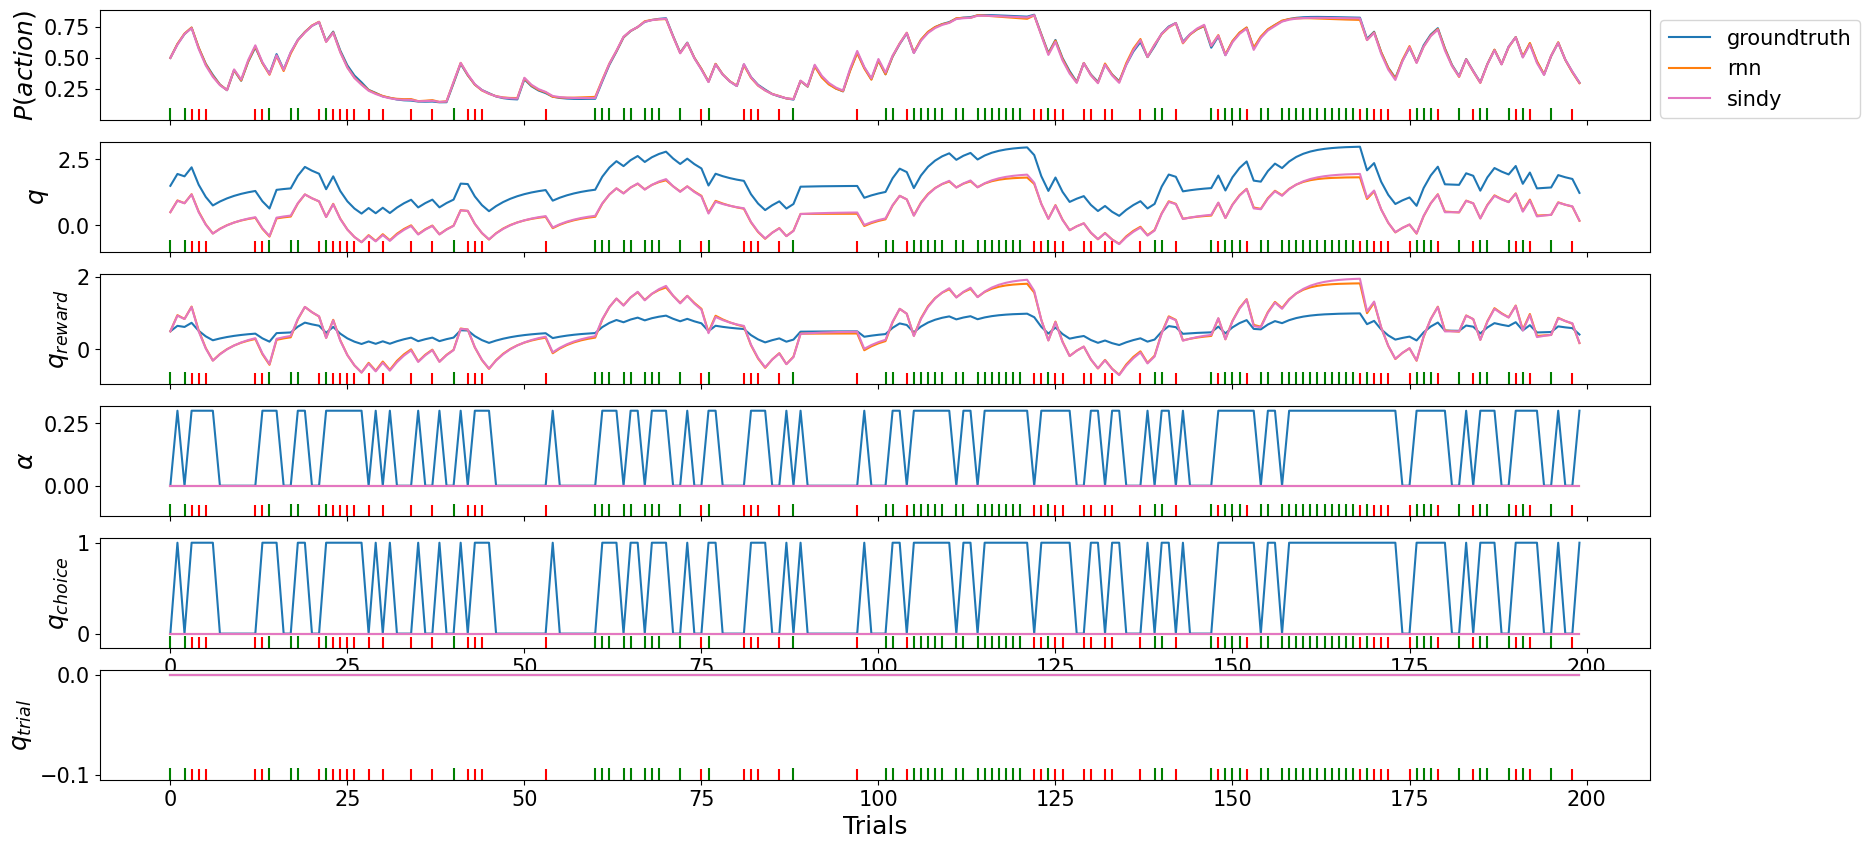

In [9]:
from spice.utils.plotting import plot_session
import matplotlib.pyplot as plt

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()

## 3. Implementing the RNN as a custom module

Now, we are going to implement the RNN that discovers RW model with a forgetting mechanism. This RNN will update the values of both the chosen option, as in the previous tutorial, and has an additional module for the not chosen option.

In [5]:
from spice.resources.rnn import BaseRNN
from spice.estimator import SpiceConfig
    

FORGETTING_RNN_CONFIG = SpiceConfig(
    # Add already here the new module and update the library and filter setup.
    rnn_modules=['x_value_reward_chosen', 'x_value_reward_not_chosen'],
    
    control_parameters=['c_action', 'c_reward'],

    # The new module which handles the not-chosen value, does not need any additional inputs except for the value
    library_setup={
        'x_value_reward_chosen': ['c_reward'],
        'x_value_reward_not_chosen': [],
    },

    # Further, the new module should be applied only to the not-chosen values
    filter_setup={
        'x_value_reward_chosen': ['c_action', 1, True],
        'x_value_reward_not_chosen': ['c_action', 0, True],
    },
)

class ForgettingRNN(BaseRNN):
    
    init_values = {
        'x_value_reward': 0.5,
    }
    
    def __init__(
        self,
        n_actions,
        **kwargs,
    ):
        super(ForgettingRNN, self).__init__(n_actions=n_actions, list_signals=FORGETTING_RNN_CONFIG.spice_feature_list)
        
        # set up the submodules
        self.submodules_rnn['x_value_reward_chosen'] = self.setup_module(input_size=1)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, ids, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _, _ = inputs
                
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('x_value_reward_chosen', self.state['x_value_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            # Let's perform the belief update for the reward-based value of the chosen option
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=reward,
                )

            # Now a RNN-module updates the not-chosen reward-based value instead of keeping it the same
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # keep track of the updated value in the memory state
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of this value in the output array
            logits[timestep] = self.state['x_value_reward']
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()    

Library setup is valid. All keys and features appear in the provided list of features.


Now that we implemented our RNN, we can train it to see how well it fits the behavior of our synthetic participant.

In [10]:
from spice.estimator import SpiceEstimator


spice_estimator = SpiceEstimator(
    rnn_class=ForgettingRNN,
    spice_config=FORGETTING_RNN_CONFIG,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    spice_participant_id=0,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)


Training the RNN...
Epoch 1/1024 --- L(Train): 3.0880159; Time: 0.09s; Convergence: 1.54e+00
Epoch 2/1024 --- L(Train): 2.5148764; Time: 0.07s; Convergence: 1.06e+00
Epoch 3/1024 --- L(Train): 1.7579801; Time: 0.08s; Convergence: 9.08e-01
Epoch 4/1024 --- L(Train): 0.8714328; Time: 0.08s; Convergence: 8.97e-01
Epoch 5/1024 --- L(Train): 0.7023824; Time: 0.08s; Convergence: 5.33e-01
Epoch 6/1024 --- L(Train): 0.6978299; Time: 0.07s; Convergence: 2.69e-01
Epoch 7/1024 --- L(Train): 0.6813845; Time: 0.07s; Convergence: 1.43e-01
Epoch 8/1024 --- L(Train): 0.6695516; Time: 0.07s; Convergence: 7.72e-02
Epoch 9/1024 --- L(Train): 0.6637544; Time: 0.08s; Convergence: 4.15e-02
Epoch 10/1024 --- L(Train): 0.6613667; Time: 0.08s; Convergence: 2.20e-02
Epoch 11/1024 --- L(Train): 0.6599789; Time: 0.07s; Convergence: 1.17e-02
Epoch 12/1024 --- L(Train): 0.6586664; Time: 0.07s; Convergence: 6.49e-03
Epoch 13/1024 --- L(Train): 0.6573032; Time: 0.08s; Convergence: 3.93e-03
Epoch 14/1024 --- L(Train)

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_value_reward_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 8.6294e-02 ... 2.7000e-01 ... 1.8510e-01 ... 2.7410e-01
        10 ... 3.2820e-01 ... 2.7000e-01 ... 1.7781e-01 ... 5.0872e-01
        20 ... 3.3035e-01 ... 2.7000e-01 ... 1.7778e-01 ... 5.1084e-01
(x_value_reward_chosen)[k+1] = -0.445 1 + 0.700 x_value_reward_chosen[k] + 0.912 c_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.0284e-01 ... 1.0978e-01 ... 7.3191e-02 ... 3.7712e-01
        10 ... 3.5257e-01 ... 1.0806e-01 ... 7.1667e-02 ... 4.2532e-01
(x_value_reward_not_chosen)[k+1] = 0.804 x_value_reward_not_chosen[k]


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

SPICE training finished.
Training took 32.30 seconds.


Let's see how our model behaves with respect to our synthetic participant.

In the following plot you can compare the action probabilities P(action), the Q-Value, the reward-based as well as the choice-based values.
(You can ignore for now the learning rate $\alpha$)

After initializing and fitting the SINDy-agent, we can now finally inspect whether all these steps resulted in well identified cognitive dynamics!

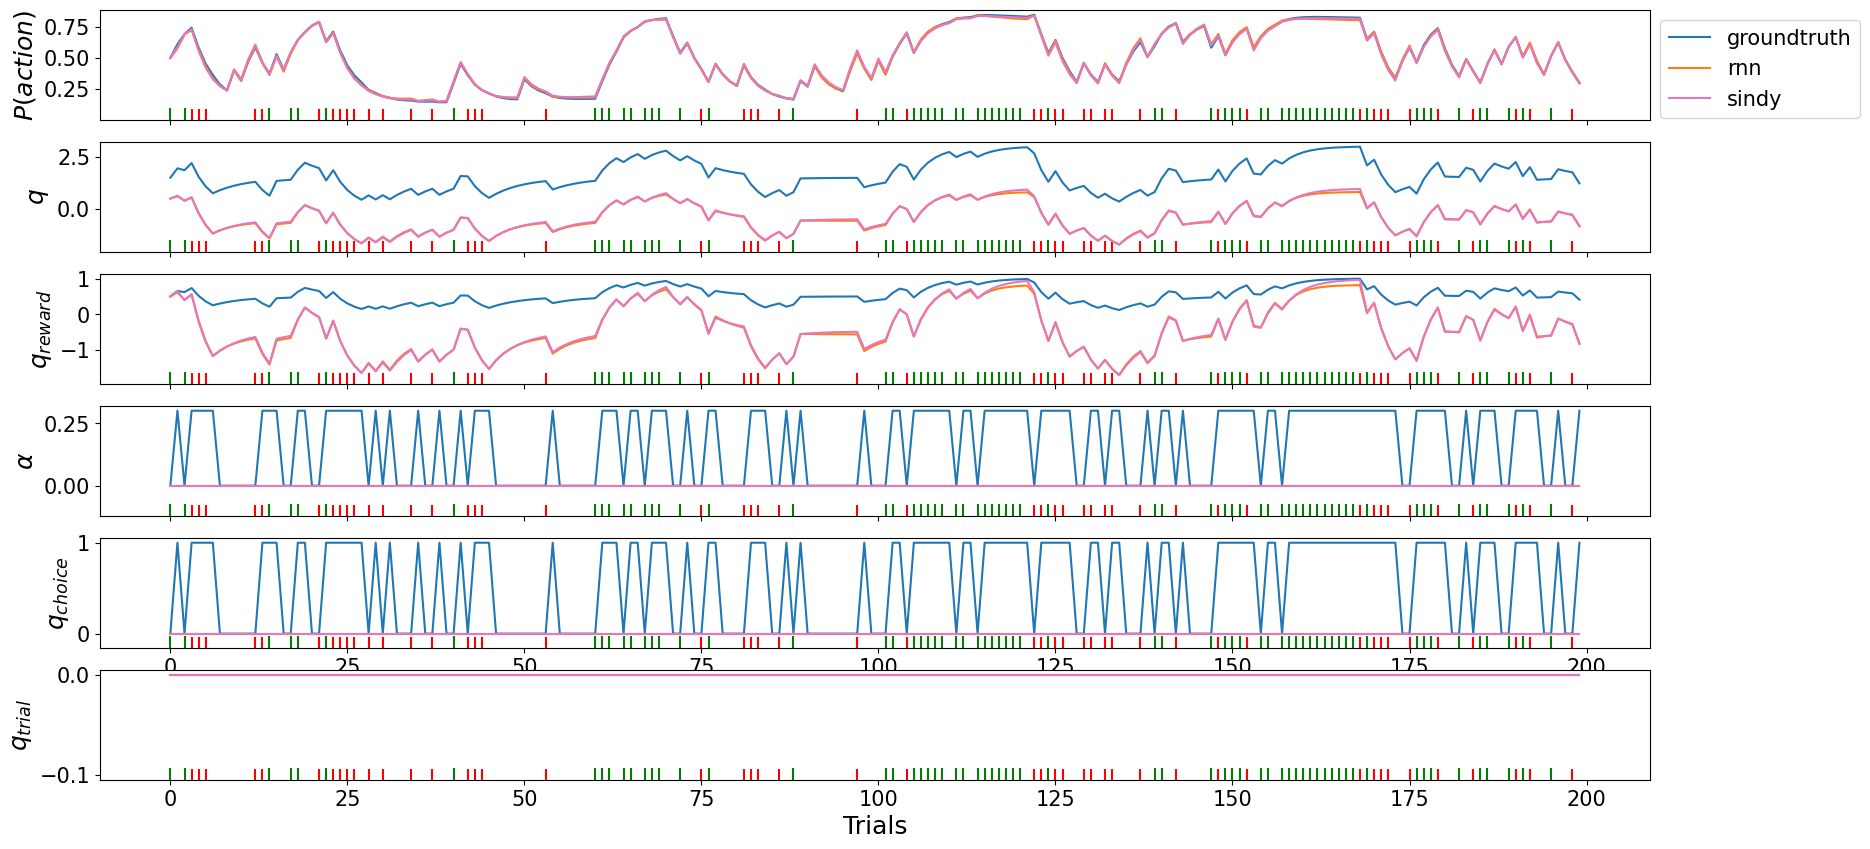

In [7]:
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.spice_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()